文档： https://github.com/ChannelCMT/vnpy_crypto/tree/master/vnpy/trader/utils/templates

## cciMacd example

In [7]:
class cciMacdSignal():

    def __init__(self):
        self.strategyName = 'cciMacd'
        
    def macdStatus(self, am, paraDict):
        fastPeriod = paraDict["fastPeriod"]
        slowPeriod = paraDict["slowPeriod"]
        sigPeriod = paraDict["sigPeriod"]

        macd, macdSig, _ = ta.MACD(am.close, fastPeriod, slowPeriod, sigPeriod)
        momDirection = 1 if macd[-1]>macdSig[-1] else -1
        
        return momDirection, macd, macdSig

    def cciEntrySignal(self, am, paraDict):
        cciPeriod = paraDict["cciPeriod"]
        cciThreshold = paraDict["cciEntryThreshold"]
        cci = ta.CCI(am.high, am.low, am.close, cciPeriod)

        cciSig = 0
        if cci[-1]>cciThreshold:
            cciSig = 1
        elif cci[-1]<-cciThreshold:
            cciSig = -1
        return cciSig, cci
    
    def exitSignal(self, am, paraDict):
        cciPeriod = paraDict["cciPeriod"]
        cciExitThreshold = paraDict["cciExitThreshold"]
        fastPeriod = paraDict["fastPeriod"]
        slowPeriod = paraDict["slowPeriod"]
        sigPeriod = paraDict["sigPeriod"]

        cci = ta.CCI(am.high, am.low, am.close, cciPeriod)
        macd, macdSig, _ = ta.MACD(am.close, fastPeriod, slowPeriod, sigPeriod)
        momDirection = 1 if macd[-1]>macdSig[-1] else -1

        exitLong, exitShort = 0, 0
        if cci[-1]<cciExitThreshold or momDirection<0:
            exitLong = 1
        if cci[-1]>-cciExitThreshold or momDirection>0:
            exitShort = 1
        return exitLong, exitShort

In [10]:
from vnpy.trader.vtConstant import *
import numpy as np
import talib as ta
import pandas as pd
from datetime import timedelta, datetime
from vnpy.trader.utils.templates.orderTemplate import * 
from vnpy.trader.app.ctaStrategy import ctaBase

########################################################################
class cciMacdStrategy(OrderTemplate):
    className = 'cciMacd'

    # 参数列表，保存了参数的名称
    paraDict = {
                "barPeriod": 600,
                "timeframeMap" : {"signalPeriod":"15m"},
                "fastPeriod":40,
                "slowPeriod": 400,
                "sigPeriod": 120,
                "cciPeriod": 200,
                "cciEntryThreshold":100,
                "cciExitThreshold": 75, 
                "stoplossPct": 0.05
                }

    # ----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
        self.symbol = self.symbolList[0]
        self.algorithm = cciMacdSignal()
        self.lot = 10
        for key, value in self.paraDict.items():
            setattr(self, key, value)

        self.orderDict = {
                         'orderLongSet1':set(), 'orderShortSet1':set(), 
                         'orderLongSet2':set(), 'orderShortSet2':set(), 
                         }
        
        # 打印全局信号的字典
        self.globalStatus = {}

        self.chartLog = {
                'datetime':[],
                'macd':[],
                'macdSig':[],
                'cci':[]
                }

    def prepare_data(self):
        for timeframe in list(set(self.timeframeMap.values())):
            self.registerOnBar(self.symbol, timeframe, None)

    def arrayPrepared(self, period):
        am = self.getArrayManager(self.symbol, period)
        if not am.inited:
            return False, None
        else:
            return True, am

    # ----------------------------------------------------------------------
    def onInit(self):
        self.setArrayManagerSize(self.barPeriod)
        self.prepare_data()
        self.putEvent()

    # ----------------------------------------------------------------------
    def onStart(self):
        self.putEvent()

    # ----------------------------------------------------------------------
    def onStop(self):
        self.putEvent()

    # 定时清除已经出场的单
    def delOrderID(self, orderSet):
        for orderId in list(orderSet):
            op = self._orderPacks[orderId]
            # 检查是否完全平仓
            if self.orderClosed(op):
                # 在记录中删除
                orderSet.discard(orderId)
    
    # 获得执行价格
    def priceExecute(self, bar):
        return bar.close*1.01, bar.close*0.99

    # 获取当前的持有仓位
    def getHoldVolume(self, orderSet):
        pos = 0
        for orderID in orderSet:
            op = self._orderPacks[orderID]
            holdVolume = op.order.tradedVolume
            pos+= holdVolume
        return pos

    def onBar(self, bar):
        # 必须继承父类方法
        super().onBar(bar)
        # on bar下触发回测洗价逻辑
        # 定时控制，开始
        self.checkOnPeriodStart(bar)
        # 定时清除已出场的单
        self.checkOnPeriodEnd(bar)
        for idSet in self.orderDict.values():
            self.delOrderID(idSet)
        # 执行策略逻辑
        self.strategy(bar)

    def on15MinBar(self, bar):
        longVolume = self.getHoldVolume(self.orderDict['orderLongSet1'])
        shortVolume = self.getHoldVolume(self.orderDict['orderShortSet1'])
        self.writeCtaLog('globalStatus%s'%(self.globalStatus))
        self.writeCtaLog('longVolume:%s, shortVolume:%s'%(longVolume, shortVolume))

    def strategy(self, bar):
        signalPeriod= self.timeframeMap["signalPeriod"]
        # 根据出场信号出场
        exitLong, exitShort = self.exitSignal(signalPeriod)
        self.exitOrder(bar, exitLong, exitShort)
        # 根据进场信号进场
        entrySig = self.entrySignal(signalPeriod)
        self.entryOrder(bar, entrySig)

    def exitSignal(self, signalPeriod):
        exitLong, exitShort = 0, 0
        arrayPrepared, amSignal = self.arrayPrepared(signalPeriod)
        if arrayPrepared:
            exitLong, exitShort = self.algorithm.exitSignal(amSignal, self.paraDict)
        return exitLong, exitShort

    def exitOrder(self, bar, exitLong, exitShort):
        if exitLong:
            for orderID in (self.orderDict['orderLongSet1']|self.orderDict['orderLongSet2']):
                op = self._orderPacks[orderID]
                self.composoryClose(op)
        if exitShort:
            for orderID in (self.orderDict['orderShortSet1']|self.orderDict['orderShortSet2']):
                op = self._orderPacks[orderID]
                self.composoryClose(op)

    def entrySignal(self,signalPeriod):
        entrySig = 0
        arrayPrepared, amSignal = self.arrayPrepared(signalPeriod)

        if arrayPrepared:
            momDirection, macd, macdSig = self.algorithm.macdStatus(amSignal, self.paraDict)
            cciSig, cci = self.algorithm.cciEntrySignal(amSignal, self.paraDict)
            self.globalStatus['momDirection'] = momDirection
            self.globalStatus['cciSig'] = cciSig

            self.chartLog['datetime'].append(datetime.strptime(amSignal.datetime[-1], "%Y%m%d %H:%M:%S"))
            self.chartLog['macd'].append(macd[-1])
            self.chartLog['macdSig'].append(macdSig[-1])
            self.chartLog['cci'].append(cci[-1])

            if momDirection==1 and cciSig==1:
                entrySig = 1
            elif momDirection==-1 and cciSig==-1:
                entrySig = -1
        return entrySig

    def entryOrder(self, bar, entrySig):
        buyExecute, shortExecute = self.priceExecute(bar)
        if entrySig ==1:
            if not (self.orderDict['orderLongSet1']):
                # 如果回测直接下单，如果实盘就分批下单
                for orderID1 in self.timeLimitOrder(ctaBase.CTAORDER_BUY, self.symbol, buyExecute, self.lot, 120).vtOrderIDs:
                    self.orderDict['orderLongSet1'].add(orderID1)
            if not (self.orderDict['orderLongSet2']):
                for orderID2 in self.timeLimitOrder(ctaBase.CTAORDER_BUY, self.symbol, buyExecute, self.lot, 120).vtOrderIDs:
                    self.orderDict['orderLongSet2'].add(orderID2)
                    op = self._orderPacks[orderID2]
                    self.setAutoExit(op, bar.close*(1-self.stoplossPct), bar.close*(1+3*self.stoplossPct))

        elif entrySig ==-1:
            if not (self.orderDict['orderShortSet1']):
                for orderID1 in self.timeLimitOrder(ctaBase.CTAORDER_SHORT, self.symbol, shortExecute, self.lot, 120).vtOrderIDs:
                    self.orderDict['orderShortSet1'].add(orderID1)
            if not (self.orderDict['orderShortSet2']):
                for orderID2 in self.timeLimitOrder(ctaBase.CTAORDER_SHORT, self.symbol, shortExecute, self.lot, 120).vtOrderIDs:
                    self.orderDict['orderShortSet2'].add(orderID2)
                    op = self._orderPacks[orderID2]
                    self.setAutoExit(op, bar.close*(1+self.stoplossPct), bar.close*(1-3*self.stoplossPct))

 # ----------------------------------------------------------------------
    def onOrder(self, order):
        super().onOrder(order)
        pass

    # ----------------------------------------------------------------------
    # 成交后用成交价设置第一张止损止盈
    def onTrade(self, trade):
        pass

    def onStopOrder(self, so):
        pass

初始仓位: {'btc_usd_cq.future:okex_LONG': 0, 'btc_usd_cq.future:okex_SHORT': 0}
2020-01-11 15:18:59.052550	开始回测
2020-01-11 15:18:59.052550	策略初始化
2020-01-11 15:19:01.134415	初始化预加载数据成功, 数据长度:43177
2020-01-11 15:19:01.134415	策略初始化完成
2020-01-11 15:19:01.134415	策略启动完成
2020-01-11 15:19:01.134415	回测时间范围:[20180701 00:00:00,20200111 15:18:59)
2020-01-11 15:19:01.134415	当前回放的时间段:[20180701 00:00:00,20200111 15:18:59)
2020-01-11 15:26:41.120027	回放结束ress: 100%    
2020-01-11 15:26:41.387754	Backtest log Recorded
2020-01-11 15:26:41.388753	计算回测结果
2020-01-11 15:26:41.540600	交割单已生成
2020-01-11 15:26:41.600538	------------------------------
2020-01-11 15:26:41.600538	第一笔交易：	2018-07-02 16:01:00
2020-01-11 15:26:41.600538	最后一笔交易：	2020-01-11 15:10:00
2020-01-11 15:26:41.600538	总交易次数：	1,177
2020-01-11 15:26:41.600538	总盈亏：	162,093.37
2020-01-11 15:26:41.600538	最大回撤: 	-50,531.39
2020-01-11 15:26:41.600538	平均每笔盈利：	137.72
2020-01-11 15:26:41.600538	平均每笔滑点：	0.0
2020-01-11 15:26:41.600538	平均每笔佣金：	109.15
2020-01-11 15

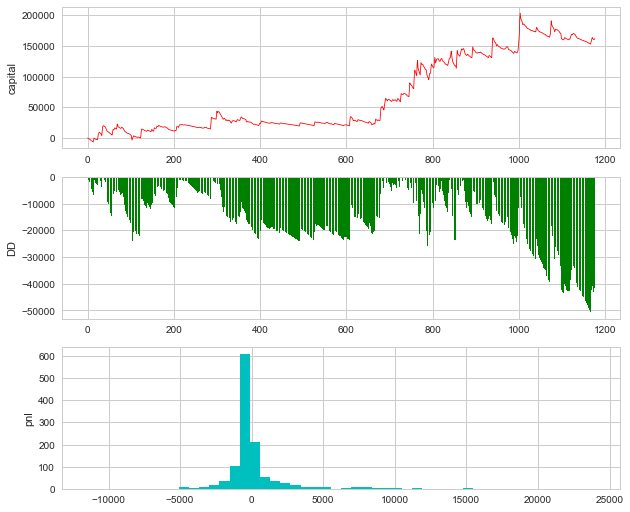

2020-01-11 15:26:45.540097	计算按日统计结果
2020-01-11 15:26:45.591044	------------------------------
2020-01-11 15:26:45.591044	首个交易日：	2018-07-01
2020-01-11 15:26:45.591044	最后交易日：	2020-01-11
2020-01-11 15:26:45.591044	总交易日：	560
2020-01-11 15:26:45.591044	盈利交易日	181
2020-01-11 15:26:45.591044	亏损交易日：	301
2020-01-11 15:26:45.591044	起始资金：	10
2020-01-11 15:26:45.591044	结束资金：	162,235.98
2020-01-11 15:26:45.591044	总收益率：	1,622,259.85%
2020-01-11 15:26:45.591044	年化收益：	695,254.22%
2020-01-11 15:26:45.591044	总盈亏：	162,225.98
2020-01-11 15:26:45.591044	最大回撤: 	-40,166.92
2020-01-11 15:26:45.591044	百分比最大回撤: -69,459.56%
2020-01-11 15:26:45.591044	卡玛比率：	10.01
2020-01-11 15:26:45.591044	总手续费：	128,338.57
2020-01-11 15:26:45.591044	总滑点：	0.0
2020-01-11 15:26:45.591044	总成交金额：	160,423,206.87
2020-01-11 15:26:45.591044	总成交笔数：	2,350
2020-01-11 15:26:45.591044	日均盈亏：	289.69
2020-01-11 15:26:45.591044	日均手续费：	229.18
2020-01-11 15:26:45.591044	日均滑点：	0.0
2020-01-11 15:26:45.591044	日均成交金额：	286,470.01
2020-01-11 15:26:45.5910

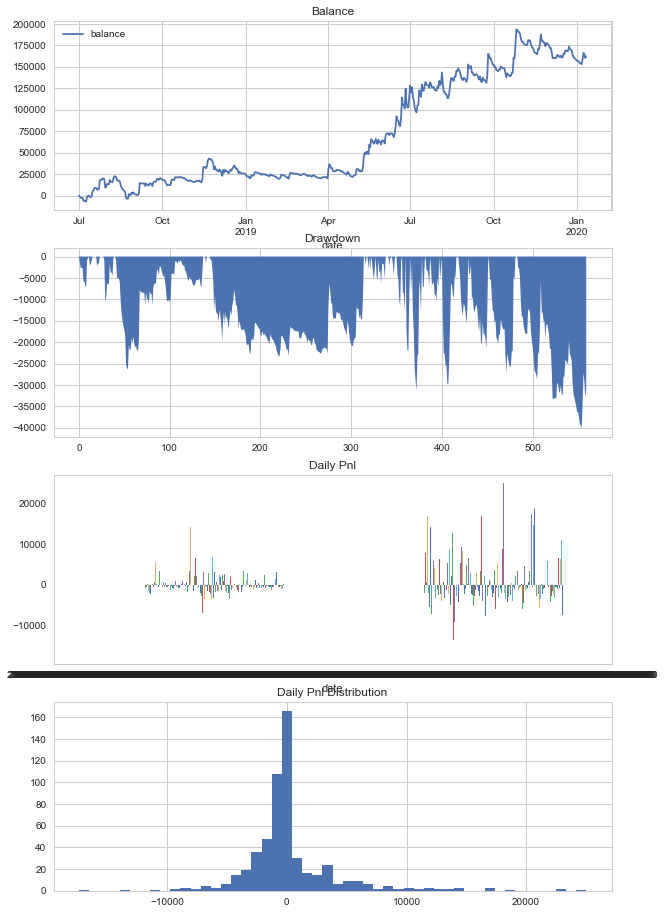

                            cci        macd     macdSig
datetime                                               
2020-01-11 13:45:00  106.616234  237.571394  138.217594
2020-01-11 14:00:00   97.573305  234.518030  139.436087
2020-01-11 14:15:00  106.797119  233.033485  140.641256
2020-01-11 14:30:00  114.807336  231.817243  141.760905
2020-01-11 14:45:00  119.053643  231.158205  142.867220


In [11]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd
from datetime import datetime
from vnpy.trader.utils import htmlplot
import json
import os

if __name__ == '__main__':
#     from cciMacdStrategy import cciMacdStrategy
    # 创建回测引擎
    engine = BacktestingEngine()
    engine.setDB_URI("mongodb://172.16.11.81:27017")
    # 设置引擎的回测模式为K线
    engine.setBacktestingMode(engine.BAR_MODE)
    # 设置使用的历史数据库
    engine.setDatabase('Kline_1Min_Auto_Db_Plus')

    # 设置回测用的数据起始日期，initHours 默认值为 0
    engine.setDataRange(datetime(2018,7,1), datetime.now(), datetime(2018,6,1))
    # 设置产品相关参数
    engine.setCapital(10)  # 设置起始资金，默认值是1,000,000
    contracts = [{
                    "symbol":"btc_usd_cq.future:okex",
                    "size" : 1, # 每点价值
                    "priceTick" : 0.001, # 最小价格变动
                    "rate" : 8/10000, # 单边手续费
                    "slippage" : 0 # 滑价
                    },]
    setting = {'symbolList': ["btc_usd_cq.future:okex"]}
    engine.setContracts(contracts)
    engine.setLog(True, "./backtestingLog")
    engine.initStrategy(cciMacdStrategy, setting)
    
    # 开始跑回测
    engine.runBacktesting()
    
    # 显示回测结果
    engine.showBacktestingResult()
    engine.showDailyResult()
    
    ### 画图分析
    chartDf = pd.DataFrame(engine.strategy.chartLog).drop_duplicates().set_index('datetime')
    print(chartDf.tail())
    mp = htmlplot.getMultiPlot(engine, freq="15m")
    mp.set_line(line=chartDf[['macd', 'macdSig', ]],colors={"macd": "red", "macdSig": "blue"}, pos=1)
    mp.set_line(line=chartDf[['cci']],colors={"rsrsAmend": "red"}, pos=2)
    mp.show()
    